In [1]:
import os, gc, zipfile, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix, classification_report,
    roc_curve, auc
)

from lightgbm import LGBMClassifier, early_stopping, log_evaluation

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams['figure.dpi'] = 110

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ieee-fraud-detection.zip to ieee-fraud-detection.zip


In [3]:
zip_path = list(uploaded.keys())[0]

In [4]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("fraud_data")   # extract into "fraud_data" folder

print("Extracted files:", os.listdir("fraud_data"))

Extracted files: ['test_identity.csv', 'sample_submission.csv', 'test_transaction.csv', 'train_transaction.csv', 'train_identity.csv']


In [5]:
train_transaction = pd.read_csv("fraud_data/train_transaction.csv")
train_identity    = pd.read_csv("fraud_data/train_identity.csv")

In [6]:
train_df = train_transaction.merge(train_identity, on="TransactionID", how="left")
print("Merged training data shape:", train_df.shape)

Merged training data shape: (590540, 434)


In [7]:
print(train_df.dtypes.value_counts())
print("\nTop missing (%):\n", train_df.isnull().mean().sort_values(ascending=False).head(10))
print("\nMemory (GB):", round(train_df.memory_usage(deep=True).sum()/1e9, 3))

float64    399
object      31
int64        4
Name: count, dtype: int64

Top missing (%):
 id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
dtype: float64

Memory (GB): 2.636


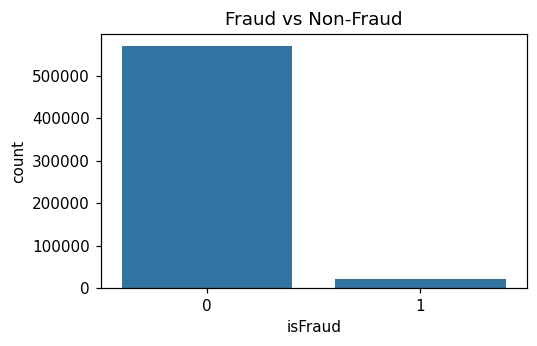

Fraudulent transactions: 3.50%


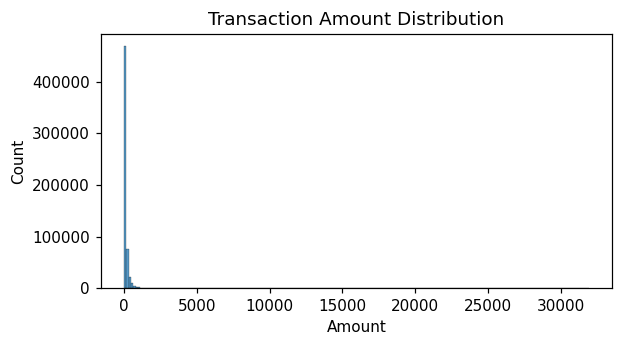


Mean Transaction Amounts by Fraud Status:
         TransactionAmt
isFraud                
0            134.511665
1            149.244779


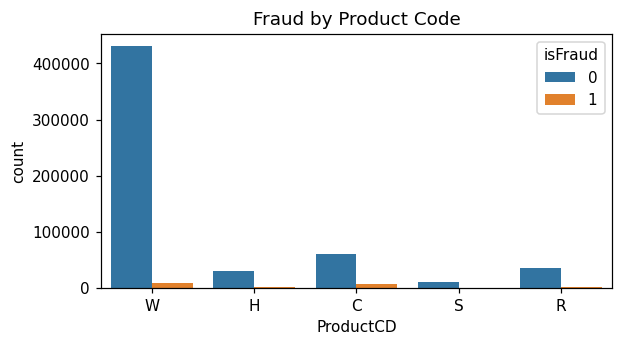


Top fraud rates for card1:
card1
18336    100.0
18318    100.0
11655    100.0
11795    100.0
12039    100.0
Name: isFraud, dtype: float64

Top fraud rates for card2:
card2
289.0    40.677966
405.0    40.350877
319.0    39.000000
176.0    36.062378
482.0    32.738095
Name: isFraud, dtype: float64

Top fraud rates for card3:
card3
132.0    100.0
125.0    100.0
139.0    100.0
181.0    100.0
175.0    100.0
Name: isFraud, dtype: float64

Top fraud rates for card4:
card4
discover            7.728161
visa                3.475610
mastercard          3.433095
american express    2.869837
Name: isFraud, dtype: float64

Top fraud rates for card5:
card5
167.0    100.000000
191.0     50.000000
107.0     33.333333
139.0     23.076923
137.0     14.718430
Name: isFraud, dtype: float64

Top fraud rates for card6:
card6
credit             6.678480
debit              2.426251
charge card        0.000000
debit or credit    0.000000
Name: isFraud, dtype: float64


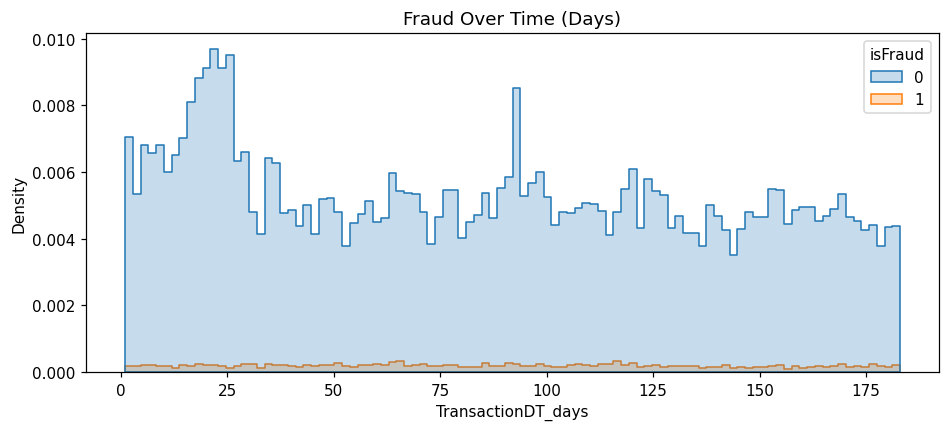

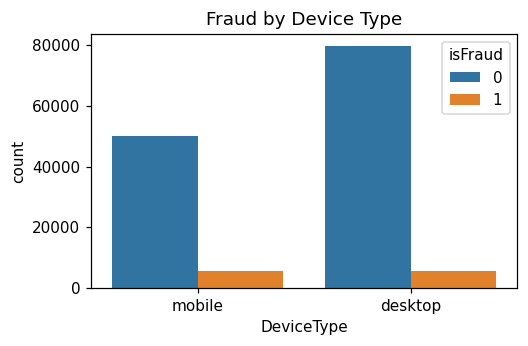

In [8]:
# =========================
# 3) EDA (KEY VIEWS)
# =========================
# 3.1 Target distribution
plt.figure(figsize=(5,3))
sns.countplot(x="isFraud", data=train_df)
plt.title("Fraud vs Non-Fraud")
plt.show()
print(f"Fraudulent transactions: {train_df['isFraud'].mean()*100:.2f}%")

# 3.2 Transaction amount distribution
plt.figure(figsize=(6,3))
sns.histplot(train_df["TransactionAmt"], bins=200, kde=False)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()
print("\nMean Transaction Amounts by Fraud Status:")
print(train_df[["TransactionAmt","isFraud"]].groupby("isFraud").mean())

# 3.3 Fraud by ProductCD
plt.figure(figsize=(6,3))
sns.countplot(x="ProductCD", hue="isFraud", data=train_df)
plt.title("Fraud by Product Code")
plt.show()

# 3.4 Card quick scan
for col in ["card1","card2","card3","card4","card5","card6"]:
    if col in train_df.columns:
        rates = train_df.groupby(col)["isFraud"].mean().sort_values(ascending=False).head(5) * 100
        print(f"\nTop fraud rates for {col}:\n{rates}")

# 3.5 Time base (create day/hour and a simple over-time density)
train_df["TransactionDT_days"] = train_df["TransactionDT"] / (24*60*60)
plt.figure(figsize=(10,4))
sns.histplot(train_df, x="TransactionDT_days", hue="isFraud", bins=100, element="step", stat="density")
plt.title("Fraud Over Time (Days)")
plt.show()



# 3.6 Device type / info (if present)
if "DeviceType" in train_df.columns:
    plt.figure(figsize=(5,3))
    sns.countplot(x="DeviceType", hue="isFraud", data=train_df)
    plt.title("Fraud by Device Type")
    plt.show()





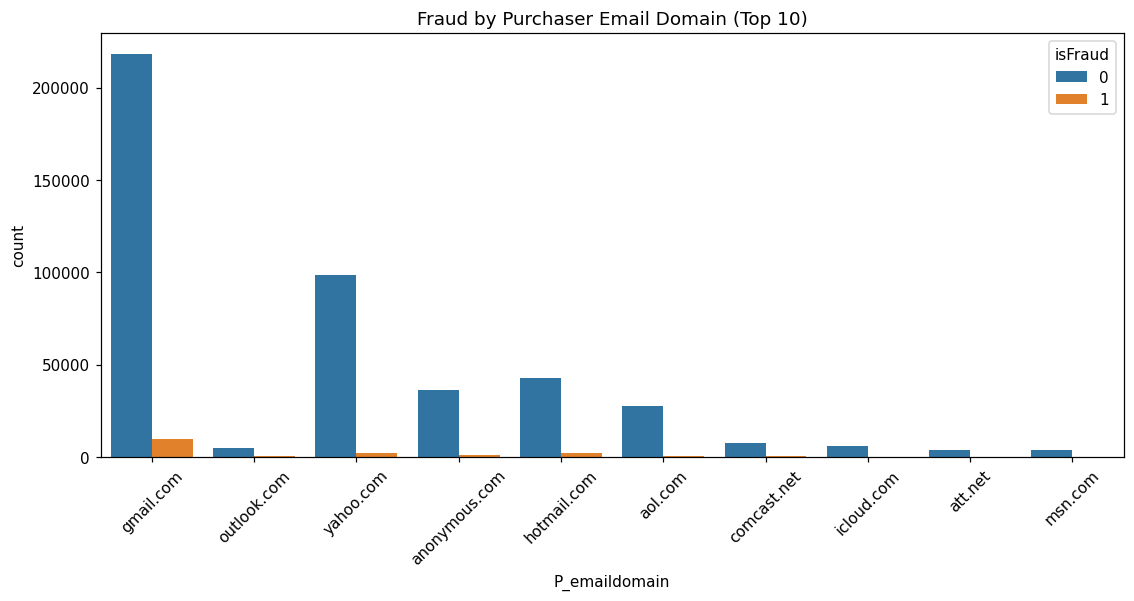

In [9]:
top_emails = train_df["P_emaildomain"].value_counts().head(10).index
plt.figure(figsize=(12,5))
sns.countplot(data=train_df[train_df["P_emaildomain"].isin(top_emails)],
              x="P_emaildomain", hue="isFraud")
plt.title("Fraud by Purchaser Email Domain (Top 10)")
plt.xticks(rotation=45)
plt.show()

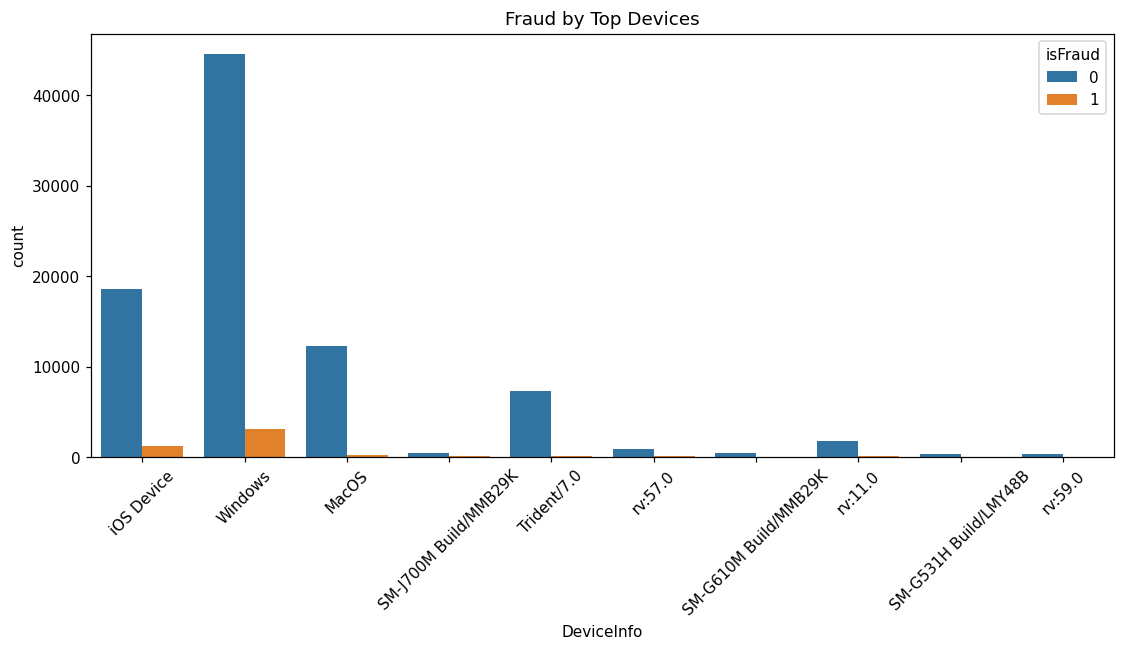

In [10]:
if "DeviceInfo" in train_df.columns:
    top_devices = train_df["DeviceInfo"].value_counts().head(10).index
    plt.figure(figsize=(12,5))
    sns.countplot(data=train_df[train_df["DeviceInfo"].isin(top_devices)],
                  x="DeviceInfo", hue="isFraud")
    plt.xticks(rotation=45)
    plt.title("Fraud by Top Devices")
    plt.show()

In [11]:
# =========================
# 4) FEATURE ENGINEERING
# =========================
# Time features
train_df["DT_day"]  = (train_df["TransactionDT"] // (24*60*60)).astype(int)
train_df["DT_hour"] = ((train_df["TransactionDT"] % (24*60*60)) // 3600).astype(int)
train_df["DT_wday"] = train_df["DT_day"] % 7
train_df["is_weekend"] = train_df["DT_wday"].isin([5,6]).astype(int)

# Amount features
train_df["logAmt"] = np.log1p(train_df["TransactionAmt"])
train_df["Amt_bin"] = pd.qcut(train_df["TransactionAmt"], 10, duplicates="drop")

# --- CHANGE 1: ensure raw text dtype before grouping/compare
for c in ["P_emaildomain", "R_emaildomain", "DeviceInfo", "id_30", "id_31"]:
    if c in train_df.columns:
        train_df[c] = train_df[c].astype("object")

# Email grouping
def email_group(email):
    if pd.isna(email): return "missing"
    email = email.lower()
    free = {"gmail.com","yahoo.com","hotmail.com","aol.com","outlook.com",
            "icloud.com","protonmail.com","live.com"}
    if email in free: return "free"
    if email.endswith(".edu"): return "edu"
    return "other"

train_df["P_email_group"] = train_df["P_emaildomain"].apply(email_group)
train_df["R_email_group"] = train_df["R_emaildomain"].apply(email_group)

# --- CHANGE 2: compare grouped strings (cast to object to avoid category-mismatch)
train_df["email_match"] = (
    train_df["P_email_group"].astype("object") == train_df["R_email_group"].astype("object")
).astype(int)

# Device simplification (safe even with NaNs)
train_df["DeviceInfo"] = train_df["DeviceInfo"].str.lower().str.split().str[0]
train_df["id_30"] = train_df["id_30"].str.split().str[0]   # OS family
train_df["id_31"] = train_df["id_31"].str.split().str[0]   # Browser

# Missingness indicators
id_cols = [c for c in train_df.columns if c.startswith("id_")]
v_cols  = [c for c in train_df.columns if c.startswith("V")]
train_df["id_missing"] = train_df[id_cols].isnull().sum(axis=1)
train_df["v_missing"]  = train_df[v_cols].isnull().sum(axis=1)

# Convert remaining objects → category AFTER the logic above
for col in train_df.select_dtypes("object").columns:
    train_df[col] = train_df[col].astype("category")


In [12]:
# =========================
# 4B) GLOBAL ENCODING + COMPRESSION (BEFORE SPLIT)
# =========================

# 1) Convert Amt_bin to ordered codes on the WHOLE df
if "Amt_bin" in train_df.columns:
    train_df["Amt_bin"] = pd.Categorical(train_df["Amt_bin"], ordered=True).codes.astype("int16")

# 2) Convert all remaining object/category to category codes ONCE
cat_cols = train_df.select_dtypes(include=["object","category"]).columns.tolist()
for c in cat_cols:
    train_df[c] = pd.Categorical(train_df[c])
    # -1 marks NaN by default; int32 is a good balance
    train_df[c] = train_df[c].cat.codes.astype("int32")

# 3) Downcast numeric columns IN-PLACE to shrink RAM
def downcast_inplace(df):
    for c in df.columns:
        col = df[c]
        if pd.api.types.is_float_dtype(col):
            df[c] = col.astype("float32")
        elif pd.api.types.is_integer_dtype(col):
            # keep negatives from category codes; fit into int16 if possible
            if col.min() >= np.iinfo(np.int16).min and col.max() <= np.iinfo(np.int16).max:
                df[c] = col.astype("int16")
            else:
                df[c] = col.astype("int32")
    return df

train_df = downcast_inplace(train_df)

# 4) Drop ultra-sparse / constant columns ONCE on the full df
missing_ratio = train_df.isna().mean()
drop_sparse = missing_ratio[missing_ratio > 0.95].index.tolist()

nunique = train_df.nunique(dropna=False)
drop_const = nunique[nunique <= 1].index.tolist()

to_drop_global = sorted(set(drop_sparse + drop_const))
if to_drop_global:
    train_df.drop(columns=to_drop_global, inplace=True, errors='ignore')

import gc; gc.collect()
print(f"[4B] Dropped {len(to_drop_global)} cols; current shape: {train_df.shape}")


[4B] Dropped 7 cols; current shape: (590540, 439)


In [13]:
# =========================
# 5) TIME-AWARE SPLIT (LIGHT-WEIGHT)
# =========================
# Sort by time & build holdout = last ~30 days
train_df = train_df.sort_values("TransactionDT")
cutoff_day = train_df["DT_day"].max() - 30

mask_train = train_df["DT_day"] < cutoff_day
mask_val   = ~mask_train

y_train = train_df.loc[mask_train, "isFraud"].astype("int8")
y_val   = train_df.loc[mask_val,   "isFraud"].astype("int8")

# Never include target/TransactionID as features
feature_cols = [c for c in train_df.columns if c not in ("isFraud","TransactionID")]

# Using .loc with boolean masks avoids extra copies vs chaining filters multiple times
X_train = train_df.loc[mask_train, feature_cols]
X_val   = train_df.loc[mask_val,   feature_cols]

import gc; gc.collect()
print(f"Train: {X_train.shape} | Val: {X_val.shape}")


Train: (501214, 437) | Val: (89326, 437)


In [14]:
# =========================
# 6) TRAIN LIGHTGBM + BASE METRICS
# =========================
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = LGBMClassifier(
    n_estimators=4000, learning_rate=0.03,
    num_leaves=128, max_depth=-1, min_child_samples=80,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight, n_jobs=-1,
    force_row_wise=True, objective="binary", metric="auc"
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=200, first_metric_only=True),
               log_evaluation(period=100)]
)

val_proba = model.predict_proba(X_val)[:, 1]
print("ROC-AUC:", roc_auc_score(y_val, val_proba))
print("PR-AUC :", average_precision_score(y_val, val_proba))


[LightGBM] [Info] Number of positive: 17549, number of negative: 483665
[LightGBM] [Info] Total Bins 34705
[LightGBM] [Info] Number of data points in the train set: 501214, number of used features: 436
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035013 -> initscore=-3.316396
[LightGBM] [Info] Start training from score -3.316396
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.916613
[200]	valid_0's auc: 0.923699
[300]	valid_0's auc: 0.92276
[400]	valid_0's auc: 0.921859
Early stopping, best iteration is:
[212]	valid_0's auc: 0.92403
Evaluated only: auc
ROC-AUC: 0.9240303905286906
PR-AUC : 0.5557993798999135


Best F2: 0.560 at threshold 0.6440
Thr for Prec ≥ 0.90: 0.9848 | Recall ≈ 0.168


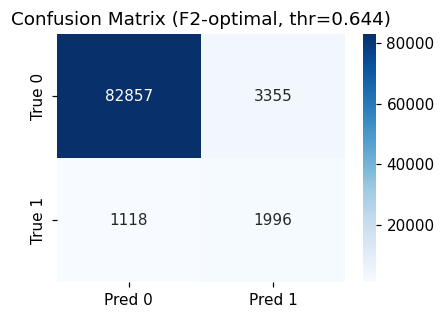


F2-optimal @ thr=0.644
              precision    recall  f1-score   support

           0      0.987     0.961     0.974     86212
           1      0.373     0.641     0.472      3114

    accuracy                          0.950     89326
   macro avg      0.680     0.801     0.723     89326
weighted avg      0.965     0.950     0.956     89326



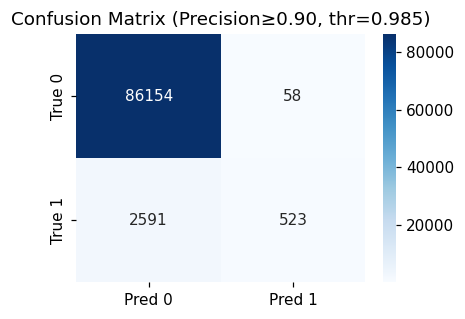


Precision≥0.90 @ thr=0.985
              precision    recall  f1-score   support

           0      0.971     0.999     0.985     86212
           1      0.900     0.168     0.283      3114

    accuracy                          0.970     89326
   macro avg      0.935     0.584     0.634     89326
weighted avg      0.968     0.970     0.960     89326



In [15]:
# =========================
# 7) THRESHOLD TUNING + CONFUSION MATRICES
# =========================
prec, rec, thr = precision_recall_curve(y_val, val_proba)

# F2-optimal
beta = 2
f2 = (1+beta**2) * (prec*rec) / (beta**2 * prec + rec + 1e-9)
best_idx = int(np.nanargmax(f2))
thr_f2 = thr[max(best_idx-1, 0)]
print(f"Best F2: {f2[best_idx]:.3f} at threshold {thr_f2:.4f}")

# Precision ≥ 0.90
idx_p90 = np.where(prec[:-1] >= 0.90)[0]
thr_p90 = thr[idx_p90[0]] if len(idx_p90) else 0.99
if len(idx_p90):
    print(f"Thr for Prec ≥ 0.90: {thr_p90:.4f} | Recall ≈ {rec[idx_p90[0]]:.3f}")

# Confusion Matrices
for name, t in {"F2-optimal": thr_f2, "Precision≥0.90": thr_p90}.items():
    y_hat = (val_proba >= t).astype(int)
    cm = confusion_matrix(y_val, y_hat)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
    plt.title(f"Confusion Matrix ({name}, thr={t:.3f})")
    plt.tight_layout(); plt.show()
    print(f"\n{name} @ thr={t:.3f}")
    print(classification_report(y_val, y_hat, digits=3))


In [16]:
# =========================
# 8) PLOTS (ROC/PR/IMPORTANCE) + SAVE PNGs
# =========================
os.makedirs("images", exist_ok=True)

# ROC
fpr, tpr, _ = roc_curve(y_val, val_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig("images/roc_curve.png", dpi=200); plt.close()

# PR
pr_auc = average_precision_score(y_val, val_proba)
plt.figure()
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig("images/pr_curve.png", dpi=200); plt.close()

# Confusion matrices saved
for name, t in {"f2_opt": thr_f2, "prec90": thr_p90}.items():
    y_hat = (val_proba >= t).astype(int)
    cm = confusion_matrix(y_val, y_hat)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
    plt.title(f"Confusion Matrix ({name}, thr={t:.3f})")
    plt.tight_layout(); plt.savefig(f"images/confusion_{name}.png", dpi=200); plt.close()

# Feature importance (gain)
gain_imp = pd.Series(
    model.booster_.feature_importance(importance_type="gain"),
    index=X_train.columns
).sort_values(ascending=False)

plt.figure(figsize=(7,9))
gain_imp.head(25).iloc[::-1].plot(kind="barh")
plt.title("Top 25 Feature Importances (gain)")
plt.tight_layout(); plt.savefig("images/feature_importance.png", dpi=200); plt.close()


In [17]:
# =========================
# 9) OPTIONAL: SHAP EXPLAINABILITY (SAMPLED)
# =========================
import shap
explainer = shap.TreeExplainer(model)

sample_n = min(5000, len(X_val))
sample_idx = np.random.choice(len(X_val), sample_n, replace=False)
X_val_sample = X_val.iloc[sample_idx]

shap_values = explainer.shap_values(X_val_sample)

# Save bar summary
shap.summary_plot(shap_values, X_val_sample, plot_type="bar", max_display=15, show=False)
plt.tight_layout(); plt.savefig("images/shap_summary_bar.png", dpi=200); plt.close()

# Save beeswarm
shap.summary_plot(shap_values, X_val_sample, max_display=15, show=False)
plt.tight_layout(); plt.savefig("images/shap_beeswarm.png", dpi=200); plt.close()


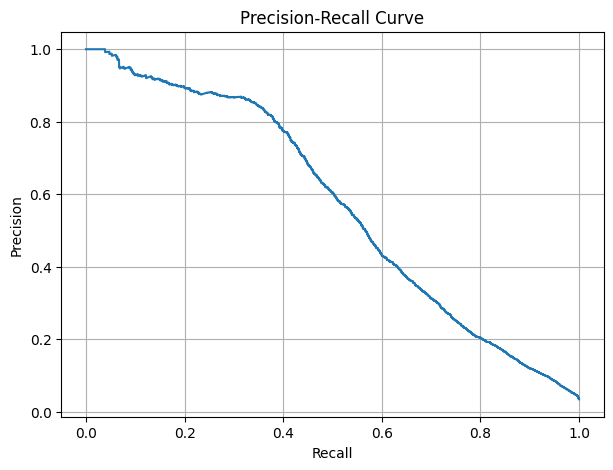

In [34]:
import shap
prec, rec, thr = precision_recall_curve(y_val, val_proba)

plt.figure(figsize=(7,5))
plt.plot(rec, prec, label=f"PR-AUC = {average_precision_score(y_val, val_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)



Top 20 Features:
 R_email_group     944875.333260
V70               766051.977421
C14               681127.332893
V317              673138.216915
V258              569900.839878
card2             492336.170853
D2                481302.486938
card1             465031.293140
C2                434601.827457
TransactionAmt    394186.195644
C13               392008.405804
addr1             367866.995617
D15               294361.949112
C1                288509.235664
TransactionDT     238170.700775
card6             230277.354460
P_emaildomain     223203.095634
V91               211958.792458
D1                206253.586521
C11               192427.117069
dtype: float64


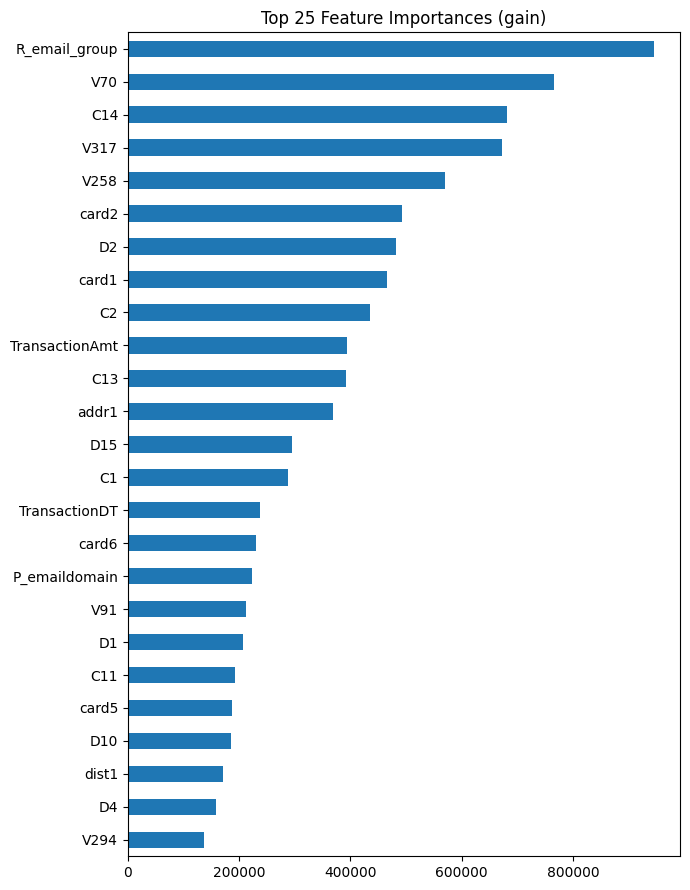

In [36]:
gain_imp = pd.Series(model.booster_.feature_importance(importance_type="gain"),
                     index=X_train_enc.columns).sort_values(ascending=False)

print("\nTop 20 Features:\n", gain_imp.head(20))

plt.figure(figsize=(7,9))
gain_imp.head(25).iloc[::-1].plot(kind="barh")
plt.title("Top 25 Feature Importances (gain)")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


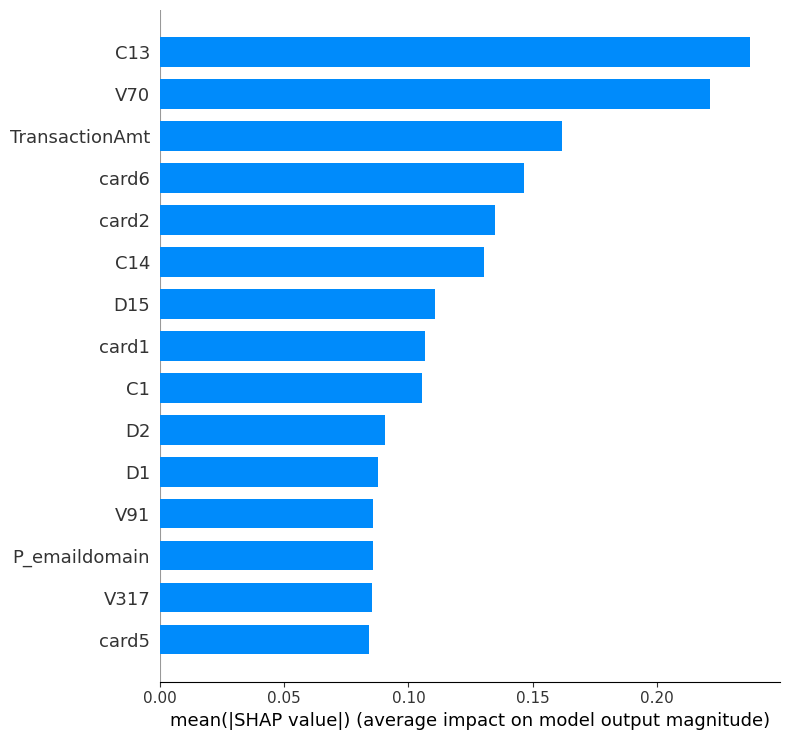

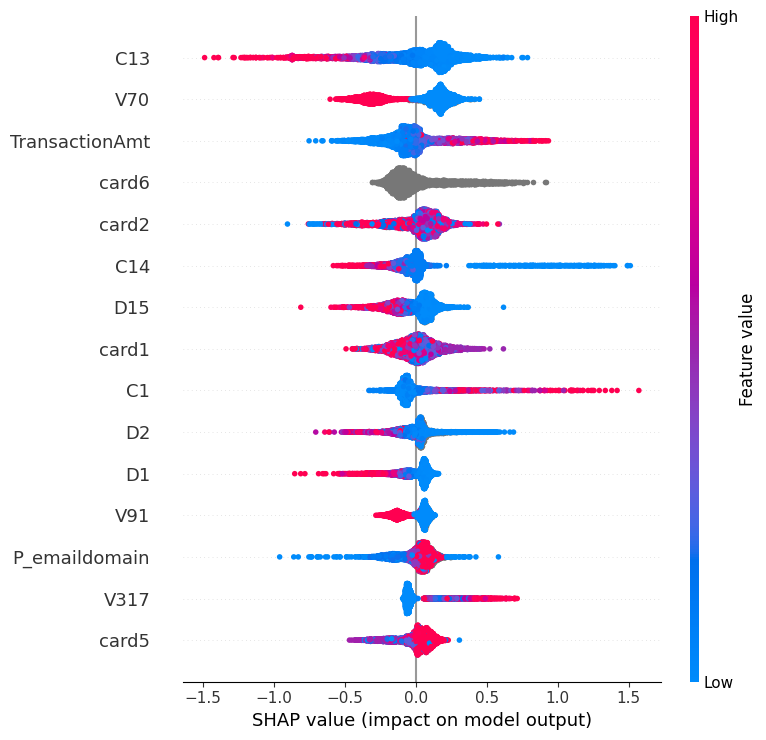

In [37]:
explainer = shap.TreeExplainer(model)
sample_idx = np.random.choice(len(X_val_enc), 5000, replace=False)
shap_values = explainer.shap_values(X_val_enc.iloc[sample_idx])

# Summary plot
shap.summary_plot(shap_values, X_val_enc.iloc[sample_idx], plot_type="bar", max_display=15)
shap.summary_plot(shap_values, X_val_enc.iloc[sample_idx], max_display=15)